Let's analyze the publicly available data about the Art Institute of Chicago's collection. Maybe there's some cool shit idk

In [51]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt 
import textwrap
from PIL import Image
from io import BytesIO
import random

In [2]:
aic = pd.read_json('allArtworks.jsonl', lines = True)
aic.head(10)

,id,title,main_reference_number,department_title,artist_title
0,4,Priest and Boy,1880.1,Prints and Drawings,Lawrence Carmichael Earle
1,9,"Interior of St. Mark's, Venice",1887.232,Arts of the Americas,David Dalhoff Neal
2,11,Self-Portrait,1887.234,Arts of the Americas,Walter Shirlaw
3,16,The Fall of the Giants,1887.249,Prints and Drawings,Salvator Rosa
4,19,"View of Ponte Lugano on the Anio, from Views o...",1887.252,Prints and Drawings,Giovanni Battista Piranesi
5,20,It Rocks but is Not Sunk,1909.182,Prints and Drawings,Charles Meryon
6,22,"Villa Pamphili outside Porta S. Pancrazio, fro...",1887.255,Prints and Drawings,Giovanni Battista Piranesi
7,23,The Arch of Septimus Severus,1887.256,Prints and Drawings,Luigi Rossini
8,24,Portrait of Edouard Molé,1887.265,Prints and Drawings,Robert Nanteuil
9,25,Jeronimo de Bran,1887.266,Prints and Drawings,Lucas Emil Vorsterman


Let's start by understanding some basic facts about the size and scale of AIC's collection 

In [3]:
aic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132769 entries, 0 to 132768
Data columns (total 5 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   id                     132769 non-null  int64 
 1   title                  132768 non-null  object
 2   main_reference_number  132769 non-null  object
 3   department_title       126212 non-null  object
 4   artist_title           114074 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.1+ MB


In [4]:
unique_artists = aic['artist_title'].unique()
depts = aic['department_title'].unique()

print(f"{len(unique_artists)} different artists")
print(f"{len(depts)} different departments ")


13967 different artists
16 different departments 


Let's take a look at all the different departments to see how art is categorized. 

In [5]:
print(depts)

['Prints and Drawings' 'Arts of the Americas' 'Arts of Asia'
 'Applied Arts of Europe'
 'Arts of the Ancient Mediterranean and Byzantium' None 'Textiles'
 'Arts of Africa' 'Painting and Sculpture of Europe' 'Modern Art'
 'Photography and Media' 'Contemporary Art' 'Architecture and Design'
 'Modern and Contemporary Art'
 'Ryerson and Burnham Libraries Special Collections' 'AIC Archives']


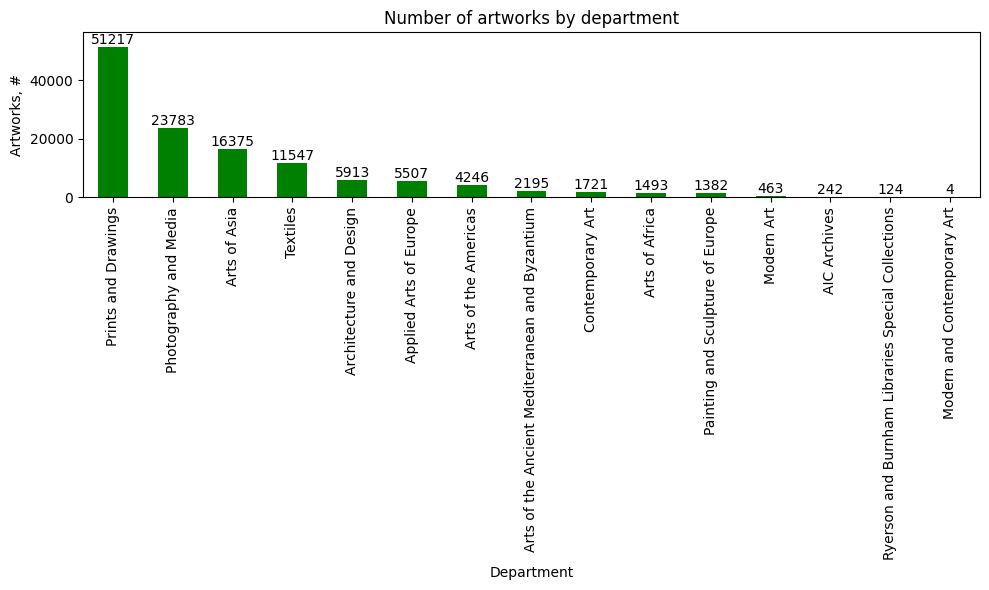

In [9]:
dept_counts = aic['department_title'].value_counts()

#Make plot
plt.figure(figsize= (10, 6))
bars = dept_counts.plot(kind= 'bar', color = 'green') #Create bar chart 
plt.title("Number of artworks by department")
plt.xlabel('Department')
plt.ylabel('Artworks, #')

# wrapped_labels = [textwrap.fill(label, width=10) for label in dept_counts.index]
# plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels)

#Add counts on top of each bar
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate of the text
        bar.get_height(),                     # y-coordinate of the text
        int(bar.get_height()),                # text value
        ha='center',                          # horizontal alignment
        va='bottom'                           # vertical alignment
    )
plt.ylim(0, dept_counts.max() * 1.1)

plt.tight_layout()
plt.show()


It's interesting that there are only 4 artworks categorized as 'Modern and Contemporary'. Especially since there is an entire wing dedicated to that type of art. I'm curious as to what they are, and since there are only 4 we can try to render them using AIC's api.

In [12]:
modern_ids = aic[aic['department_title'] == 'Modern and Contemporary Art']['id']
print(modern_ids)


74585     124828
128547    260096
129669    263729
130307    265984
Name: id, dtype: int64


In [33]:
def generate_image(aic_id):
    aic_id = str(aic_id)
    metadata_url = f"https://api.artic.edu/api/v1/artworks/{aic_id}"
    metadata_response = requests.get(metadata_url).json()

    # Check if 'data' and 'image_id' keys are in the response
    if 'data' not in metadata_response or 'image_id' not in metadata_response['data']:
        print(f"Metadata for ID {aic_id} is missing 'image_id'.")
        return None

    # Extract the identifier for the image
    image_id = metadata_response['data']['image_id']
    image_url = f"https://www.artic.edu/iiif/2/{image_id}/full/843,/0/default.jpg"
    
    # Request the image and check for a successful response
    image_response = requests.get(image_url)
    if image_response.status_code != 200:
        print(f"Image for ID {aic_id} could not be retrieved (status code {image_response.status_code}).")
        return None
    
    # Try to open the image
    try:
        image = Image.open(BytesIO(image_response.content))
    except Exception as e:
        print(f"Error opening image for ID {aic_id}: {e}")
        return None
    
    return image

In [28]:
def get_details(aic_id):
    # Ensure aic_id is a string
    aic_id = str(aic_id)
    
    # Filter DataFrame for matching id, ensuring both sides are strings for comparison
    match = aic[aic['id'].astype(str) == aic_id]
    
    # Check if any matches are found
    if match.empty:
        print(f"No details found for ID {aic_id}")
        return None, None
    
    # Extract title and artist_name if match is found
    title = match['title'].values[0]
    artist = match['artist_title'].values[0]
    
    return title, artist
   
print(get_details(129884)) 

In [35]:
for id in modern_ids: 
    print(get_details(id))
    

('Baby Steps from the Cave', 'William T. Wiley')
('Epping II', 'Igshaan Adams')
('Woman Leaning on Her Elbow: Portrait of Katalin Dávid (Könyökére támaszkodó nö: Dávid Katalin portréja)', 'Béla Kondor')
('10/29/52', 'Helen Frankenthaler')


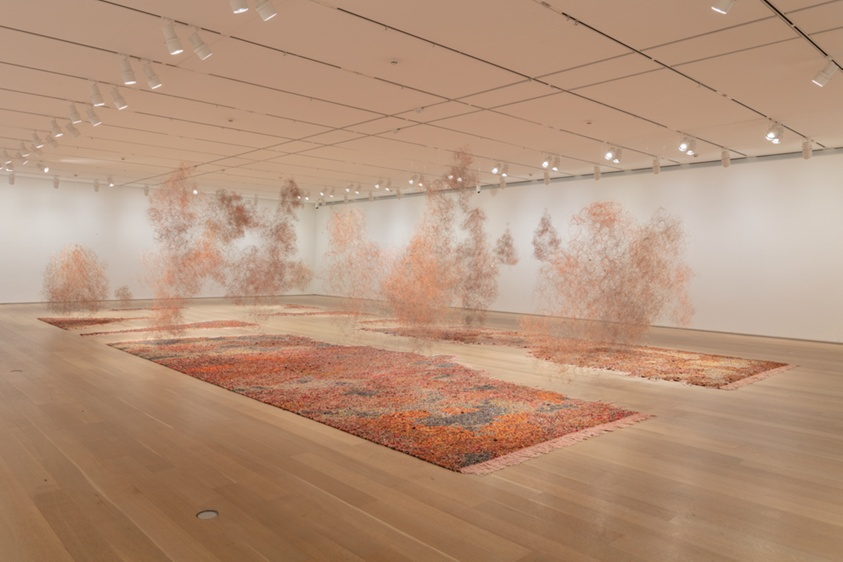

In [45]:
artist_dept_counts = aic.groupby(['artist_title', 'department_title']).size().reset_index(name= 'count')
artist_totals = artist_dept_counts.groupby('artist_title')['count'].sum().reset_index(name='total_works')
artist_dept_summary = artist_dept_counts.merge(artist_totals, on='artist_title')
artist_dept_summary = artist_dept_summary.sort_values(by='total_works', ascending=False)

artist_dept_summary.head(10)



,artist_title,department_title,count,total_works
14000,Utagawa Hiroshige,Arts of Asia,1594,1595
13999,Utagawa Hiroshige,Arts of Africa,1,1595
13940,Unknown,Photography and Media,992,1165
13937,Unknown,Applied Arts of Europe,1,1165
13938,Unknown,Architecture and Design,5,1165
13941,Unknown,Prints and Drawings,158,1165
13939,Unknown,Arts of the Americas,2,1165
13942,Unknown,Textiles,7,1165
13956,Unknown Maker,Photography and Media,1159,1159
633,Ancient Roman,Arts of Asia,1,1139


In [50]:
artist_dept_pivot = artist_dept_summary.pivot(index= 'artist_title', columns= 'department_title', values= 'count')
artist_dept_pivot = artist_dept_pivot.fillna(0)
artist_dept_pivot['total_works'] = artist_dept_pivot.sum(axis= 1)
artist_dept_pivot = artist_dept_pivot.sort_values(by='total_works', ascending=False)
total_works = artist_dept_pivot['total_works'].sum()
artist_dept_pivot['pct_of_total'] = (artist_dept_pivot['total_works'] / total_works) * 100
artist_dept_pivot['pct_of_total'] = artist_dept_pivot['pct_of_total'].map("{:.2f}%".format)
artist_dept_pivot



department_title,AIC Archives,Applied Arts of Europe,Architecture and Design,Arts of Africa,Arts of Asia,Arts of the Americas,Arts of the Ancient Mediterranean and Byzantium,Contemporary Art,Modern Art,Modern and Contemporary Art,Painting and Sculpture of Europe,Photography and Media,Prints and Drawings,Ryerson and Burnham Libraries Special Collections,Textiles,total_works,pct_of_total
artist_title,,,,,,,,,,,,,,,,,
Utagawa Hiroshige,0.0,0.0,0.0,1.0,1594.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1595.0,1.46%
Unknown,0.0,1.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,992.0,158.0,0.0,7.0,1165.0,1.06%
Unknown Maker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1159.0,0.0,0.0,0.0,1159.0,1.06%
Ancient Roman,0.0,0.0,0.0,8.0,1.0,0.0,1130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1139.0,1.04%
James McNeill Whistler,1.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1085.0,0.0,0.0,1096.0,1.00%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
James Sharples,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.00%
James Seymour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.00%
James Roy Hopkins,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00%


No artist has more than ~1.5% of the entire collection. And the artist with the most works in the AIC's collection is 'Utagawa Hiroshige'. Who woulda thunk it!

Let's do something completely differnet. Like create a function that returns a random artwork from the collection, kind of like the AIC chrome browser extension. 

In [78]:
upper_lim = aic['id'].max() 

def random_art(max_attempts=10):  # Optional parameter to limit attempts
    attempts = 0
    
    while attempts < max_attempts:
        rand_id = random.randint(1, upper_lim)
        attempts += 1
        
        try:
            # Get details for the artwork
            title, artist = get_details(rand_id)
            if title is None or artist is None:
                print(f"No details found for ID {rand_id}. Trying another ID...")
                continue  # Try another random ID
            
            # Generate the image
            image = generate_image(rand_id)
            if image is None:
                print(f"Metadata for ID {rand_id} is missing 'image_id'. Trying another ID...")
                continue  # Try another random ID
            
            # Create a plot
            fig, ax = plt.subplots()
            
            # Display the image
            ax.imshow(image)
            ax.axis('off')  # Hide axes

            # Add the title using artwork title and artist name
            plt.title(f"{title} by {artist}", fontsize=14, pad=20)

            # Show the plot with the image and title
            plt.show()
            return  # Exit the function after successful display

        except TypeError as e:
            # print(f"TypeError encountered for ID {rand_id}: {e}")
            continue
        except Exception as e:
            # print(f"An unexpected error occurred for ID {rand_id}: {e}")
            continue

    print("Max attempts reached. No valid artwork found.")


Metadata for ID 101284 is missing 'image_id'.
Metadata for ID 101284 is missing 'image_id'. Trying another ID...
No details found for ID 181914
No details found for ID 181914. Trying another ID...
No details found for ID 241193
No details found for ID 241193. Trying another ID...
Image for ID 193211 could not be retrieved (status code 404).
Metadata for ID 193211 is missing 'image_id'. Trying another ID...


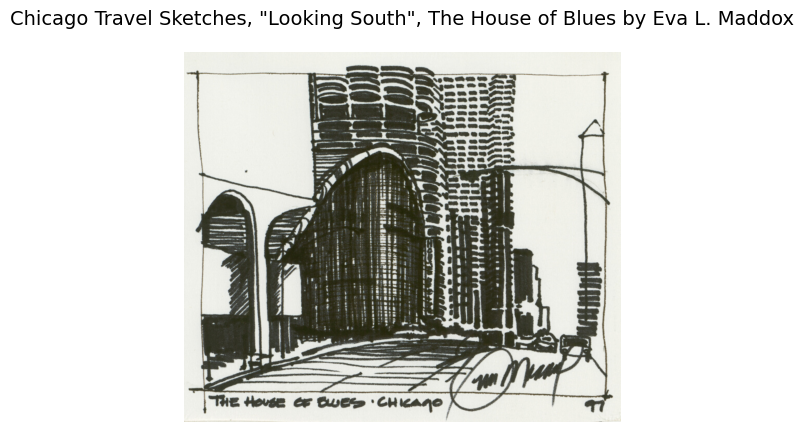

In [84]:
random_art()